- [ETL](#ETL)
- [Переобученная модель дерева решений](#Переобученная-модель-дерева-решений)

In [1]:
import os
import subprocess

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from utils import definitions as defs

In [2]:
df = pd.read_excel(defs.ETLED_DATA_PATH_step_2)

## ETL

Удаляем вспомогательные вопросы.

In [3]:
df = df.drop(['pre4. Есть ответ на вопрос 4?'], axis=1)
df = df.drop(['pre11. Есть ответ на вопрос 11?'], axis=1)
df = df.drop(['pre20. Есть ответ на вопрос 20?'], axis=1)

Меняем NaN в численных признаках на 0.

In [4]:
df.replace({defs.QUESTION_4: {np.NaN: 0}}, inplace=True)
df.replace({defs.QUESTION_24: {np.NaN: 0}}, inplace=True)

Кодируем ранговые признаки.

In [5]:
df.replace({
    defs.QUESTION_5:
    {
        defs.ANSWER_5_5: 0,
        defs.ANSWER_5_4: 1,
        defs.ANSWER_5_3: 2,
        defs.ANSWER_5_2: 3,
        defs.ANSWER_5_1: 4,
    }
}, inplace=True)

df.replace({
    defs.QUESTION_7:
    {
        np.NaN: -1,
        defs.ANSWER_7_6: 0,
        defs.ANSWER_7_5: 1,
        defs.ANSWER_7_4: 2,
        defs.ANSWER_7_3: 3,
        defs.ANSWER_7_2: 4,
        defs.ANSWER_7_1: 5,
    }
}, inplace=True)

df.replace({
    defs.QUESTION_9:
    {
        np.NaN: -1
    }
}, inplace=True)
df[defs.QUESTION_9] = df[defs.QUESTION_9].astype('int64')

df.replace({
    defs.QUESTION_11:
    {
        np.NaN: -1,
        defs.ANSWER_11_6: 0,
        defs.ANSWER_11_5: 1,
        defs.ANSWER_11_4: 2,
        defs.ANSWER_11_3: 3,
        defs.ANSWER_11_2: 4,
        defs.ANSWER_11_1: 5,
    }
}, inplace=True)

df.replace({
    defs.QUESTION_12:
    {
        defs.ANSWER_12_1: 0,
        defs.ANSWER_12_2: 1,
        defs.ANSWER_12_3: 2,
        defs.ANSWER_12_4: 3,
    }
}, inplace=True)

df.replace({
    defs.QUESTION_13:
    {
        defs.ANSWER_13_5: 0,
        defs.ANSWER_13_4: 1,
        defs.ANSWER_13_6: 2,
        defs.ANSWER_13_7: 3,
        defs.ANSWER_13_3: 4,
        defs.ANSWER_13_2: 5,
        defs.ANSWER_13_1: 6,
    }
}, inplace=True)

df.replace({
    defs.QUESTION_14:
    {
        defs.ANSWER_14_4: 0,
        defs.ANSWER_14_3: 1,
        defs.ANSWER_14_2: 2,
        defs.ANSWER_14_1: 3,
    }
}, inplace=True)

df.replace({
    defs.QUESTION_19:
    {
        defs.ANSWER_19_20_1: 0,
        defs.ANSWER_19_20_2: 1,
        defs.ANSWER_19_20_3: 2,
        defs.ANSWER_19_20_4: 3,
    }
}, inplace=True)

df.replace({
    defs.QUESTION_20:
    {
        np.NaN: -1,
        defs.ANSWER_19_20_1: 0,
        defs.ANSWER_19_20_2: 1,
        defs.ANSWER_19_20_3: 2,
        defs.ANSWER_19_20_4: 3,
    }
}, inplace=True)

df.replace({
    defs.QUESTION_26:
    {
        np.NaN: -1,
        defs.ANSWER_26_1: 0,
        defs.ANSWER_26_2: 1,
        defs.ANSWER_26_3: 2,
    }
}, inplace=True)

df.replace({
    defs.QUESTION_27:
    {
        defs.ANSWER_27_4: 0,
        defs.ANSWER_27_3: 1,
        defs.ANSWER_27_2: 2,
        defs.ANSWER_27_1: 3,
    }
}, inplace=True)

df.replace({
    defs.QUESTION_28:
    {
        defs.ANSWER_28_4: 0,
        defs.ANSWER_28_3: 1,
        defs.ANSWER_28_2: 2,
        defs.ANSWER_28_1: 3,
    }
}, inplace=True)

df.replace({
    defs.QUESTION_29:
    {
        defs.ANSWER_29_4: 0,
        defs.ANSWER_29_3: 1,
        defs.ANSWER_29_2: 2,
        defs.ANSWER_29_1: 3,
    }
}, inplace=True)

Кодируем категориальные признаки.

In [6]:
categorical_feature_names = {
    defs.QUESTION_3: defs.ANSWERS_3,
    defs.QUESTION_6: [defs.YES, defs.NO],
    defs.QUESTION_8: [defs.YES, defs.NO],
    defs.QUESTION_15: [defs.YES, defs.NO],
    defs.QUESTION_23: defs.ANSWERS_23,
    defs.QUESTION_25: defs.ANSWERS_25,
    defs.QUESTION_30: [defs.YES, defs.NO],
    defs.QUESTION_33: [defs.YES, defs.NO],
    defs.QUESTION_34: [defs.YES, defs.NO],
    defs.QUESTION_35: [defs.YES, defs.NO],
}

def encode_categorical_feature(df, feature_name, categories):
    # Столбец в DataFrame становится "категориальным". Это означает, что ячейки в нём могут
    # принимать только значения из допустимых категорий либо np.NaN. Допустимые категории
    # определяются при создании такого столбца либо множеством различных ячеек, либо
    # специальным списком. Если допустимые категории определяются специальным списком и 
    # значение ячейки не входит в этот список, её значение становится np.NaN.
    df[feature_name] = pd.Categorical(df[feature_name], categories=categories)
    # Категории кодируются числами 0, 1, 2, ... np.NaN числом -1.
    df[feature_name] = df[feature_name].cat.codes
    # Приведение к типу, допустимому для конвертации DataFrame в Dataset.
    df[feature_name] = df[feature_name].astype('int64')

for feature_name, categories in categorical_feature_names.items():
    encode_categorical_feature(df, feature_name, categories)

In [7]:
y = df[defs.LABEL]
X = df.drop(defs.LABEL, axis=1)

feature_names = list(X)

## Переобученная модель дерева решений

In [8]:
tree = DecisionTreeClassifier()
tree.fit(X, y)

DecisionTreeClassifier()

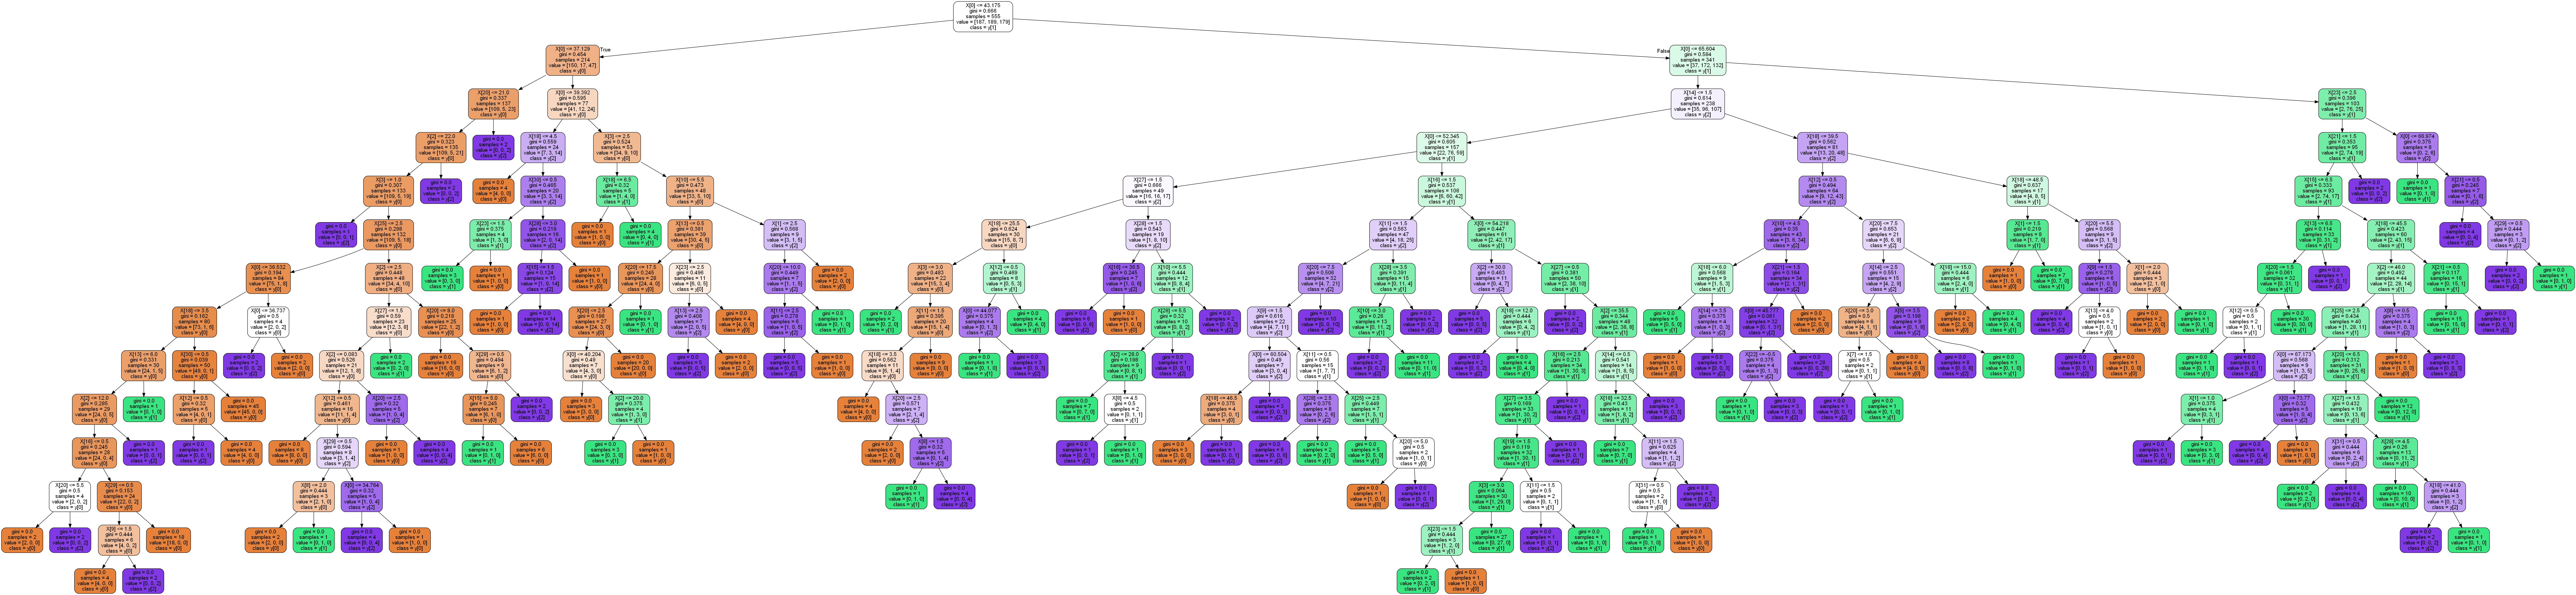

In [9]:
export_graphviz(
    tree,
    out_file='overfitted tree.gv',
    class_names=True,
    filled=True,
    rounded=True,
)
# конвертируем из .gv в .png через командую строку
subprocess.call(['dot', '-Tpng', 'overfitted tree.gv', '-o', 'overfitted tree.png'])
display.Image('overfitted tree.png')

In [10]:
# Картинки встроены в jupyter notebook. Теперь удаляем файлы, чтобы они не засоряли проект.
os.remove('overfitted tree.gv')
os.remove('overfitted tree.png')

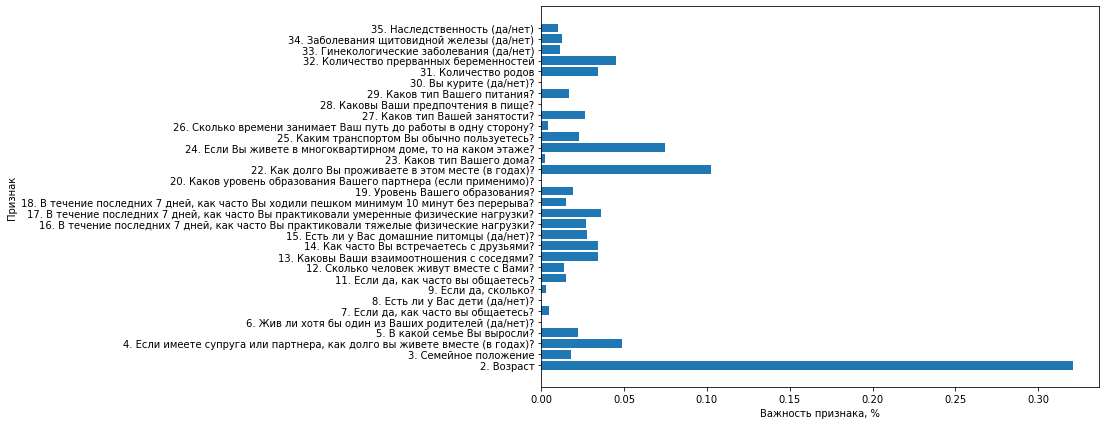

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(feature_names, tree.feature_importances_, align='center')
ax.set_xlabel('Важность признака, %')
ax.set_ylabel('Признак')

plt.show()        